# Colab FAQ

For some basic overview and features offered in Colab notebooks, check out: [Overview of Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

You need to use the colab GPU for this assignmentby selecting:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

# Download CIFAR and Colour dictionary
It can take up to a couple of minutes to download everything the first time.


## Helper code
You can ignore the restart warning.

In [1]:
######################################################################
# Setup python environment and change the current working directory
######################################################################
!pip install torch torchvision
!pip install Pillow==4.0.0
%mkdir -p /content/cs6360/a2/
%cd /content/cs6360/a2

     |████████████████████████████████| 2.1MB 2.8MB/s 
ERROR: fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.3.1+cu100 which is incompatible.
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


  Using cached https://files.pythonhosted.org/packages/89/99/0e3522a9764fe371bf9f7729404b1ef7d9c4fc49cbe5f1761c6e07812345/Pillow-4.0.0-cp27-cp27mu-manylinux1_x86_64.whl
ERROR: fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.3.1+cu100 which is incompatible.
ERROR: scikit-image 0.14.3 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: torchvision 0.4.2+cu100 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 6.2.1
    Uninstalling Pillow-6.2.1:
      Successfully uninstalled Pillow-6.2.1


/content/cs6360/a2


In [0]:
# adapted from 
# https://github.com/fchollet/keras/blob/master/keras/datasets/cifar10.py

import os
from six.moves.urllib.request import urlretrieve
import tarfile
import numpy as np
import pickle
import sys

def get_file(fname,
             origin,
             untar=False,
             extract=False,
             archive_format='auto',
             cache_dir='data'):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + '.tar.gz'
    else:
        fpath = os.path.join(datadir, fname)
    
    print(fpath)
    if not os.path.exists(fpath):
        print('Downloading data from', origin)

        error_msg = 'URL fetch failure on {}: {} -- {}'
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print('Extracting file.')
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath



def load_batch(fpath, label_key='labels'):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    f = open(fpath, 'rb')
    if sys.version_info < (3,):
        d = pickle.load(f)
    else:
        d = pickle.load(f, encoding='bytes')
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode('utf8')] = v
        d = d_decoded
    f.close()
    data = d['data']
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels

def load_cifar10(transpose=False):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = 'cifar-10-batches-py'
    origin = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    path = get_file(dirname, origin=origin, untar=True)

    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.zeros((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000: i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000: i * 10000] = labels

    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if transpose:
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)


## Download files

This may take 1 or 2 mins for the first time.

In [3]:
######################################################################
# Download CIFAR datasets and other related files
######################################################################
colours_fpath = get_file(fname='colours', 
                         origin='http://www.cs.toronto.edu/~jba/kmeans_colour_a2.tar.gz', 
                         untar=True)
m = load_cifar10()

data/colours.tar.gz
('Downloading data from', 'http://www.cs.toronto.edu/~jba/kmeans_colour_a2.tar.gz')
Extracting file.
data/cifar-10-batches-py.tar.gz
('Downloading data from', 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz')
Extracting file.


# Code for training and CNN models

## Data preprocessing

In [0]:
"""
Colourization of CIFAR-10 Horses via classification.
"""
from __future__ import print_function
import argparse
import math
import numpy as np
import numpy.random as npr
import scipy.misc
import time
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib
import matplotlib.pyplot as plt 


#from load_data import load_cifar10

HORSE_CATEGORY = 7

######################################################################
# Data related code
######################################################################
def get_rgb_cat(xs, colours):
    """
    Get colour categories given RGB values. This function doesn't
    actually do the work, instead it splits the work into smaller
    chunks that can fit into memory, and calls helper function
    _get_rgb_cat

    Args:
      xs: float numpy array of RGB images in [B, C, H, W] format
      colours: numpy array of colour categories and their RGB values
    Returns:
      result: int numpy array of shape [B, 1, H, W]
    """
    if np.shape(xs)[0] < 100:
        return _get_rgb_cat(xs)
    batch_size = 100
    nexts = []
    for i in range(0, np.shape(xs)[0], batch_size):
        next = _get_rgb_cat(xs[i:i+batch_size,:,:,:], colours)
        nexts.append(next)
    result = np.concatenate(nexts, axis=0)
    return result

def _get_rgb_cat(xs, colours):
    """
    Get colour categories given RGB values. This is done by choosing
    the colour in `colours` that is the closest (in RGB space) to
    each point in the image `xs`. This function is a little memory
    intensive, and so the size of `xs` should not be too large.

    Args:
      xs: float numpy array of RGB images in [B, C, H, W] format
      colours: numpy array of colour categories and their RGB values
    Returns:
      result: int numpy array of shape [B, 1, H, W]
    """
    num_colours = np.shape(colours)[0]
    xs = np.expand_dims(xs, 0)
    cs = np.reshape(colours, [num_colours,1,3,1,1])
    dists = np.linalg.norm(xs-cs, axis=2) # 2 = colour axis
    cat = np.argmin(dists, axis=0)
    cat = np.expand_dims(cat, axis=1)
    return cat

def get_cat_rgb(cats, colours):
    """
    Get RGB colours given the colour categories

    Args:
      cats: integer numpy array of colour categories
      colours: numpy array of colour categories and their RGB values
    Returns:
      numpy tensor of RGB colours
    """
    return colours[cats]

def process(xs, ys, max_pixel=256.0, downsize_input=False):
    """
    Pre-process CIFAR10 images by taking only the horse category,
    shuffling, and have colour values be bound between 0 and 1

    Args:
      xs: the colour RGB pixel values
      ys: the category labels
      max_pixel: maximum pixel value in the original data
    Returns:
      xs: value normalized and shuffled colour images
      grey: greyscale images, also normalized so values are between 0 and 1
    """
    xs = xs / max_pixel
    xs = xs[np.where(ys == HORSE_CATEGORY)[0], :, :, :]
    npr.shuffle(xs)
    grey = np.mean(xs, axis=1, keepdims=True)
    if downsize_input:
      avg_pool = nn.Sequential(nn.AvgPool2d(2),nn.AvgPool2d(2), 
                               nn.Upsample(scale_factor=2, mode='bilinear'), nn.Upsample(scale_factor=2, mode='bilinear'))
      grey_downsized = avg_pool.forward(torch.from_numpy(grey).float())
      grey = grey_downsized.data.numpy()
    return (xs, grey)


def get_batch(x, y, batch_size):
    '''
    Generated that yields batches of data

    Args:
      x: input values
      y: output values
      batch_size: size of each batch
    Yields:
      batch_x: a batch of inputs of size at most batch_size
      batch_y: a batch of outputs of size at most batch_size
    '''
    N = np.shape(x)[0]
    assert N == np.shape(y)[0]
    for i in range(0, N, batch_size):
        batch_x = x[i:i+batch_size, :,:,:]
        batch_y = y[i:i+batch_size, :,:,:]
        yield (batch_x, batch_y)

######################################################################
# Torch Helper
######################################################################

def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): categorical labels 
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).float()
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

def compute_loss(criterion, outputs, labels, batch_size, num_colours):
    """
    Helper function to compute the loss. Since this is a pixelwise
    prediction task we need to reshape the output and ground truth
    tensors into a 2D tensor before passing it in to the loss criteron.

    Args:
      criterion: pytorch loss criterion
      outputs (pytorch tensor): predicted labels from the model
      labels (pytorch tensor): ground truth labels
      batch_size (int): batch size used for training
      num_colours (int): number of colour categories
    Returns:
      pytorch tensor for loss
    """

    loss_out = outputs.transpose(1,3) \
                      .contiguous() \
                      .view([batch_size*32*32, num_colours])
    loss_lab = labels.transpose(1,3) \
                      .contiguous() \
                      .view([batch_size*32*32])
    return criterion(loss_out, loss_lab)

def run_validation_step(cnn, criterion, test_grey, test_rgb_cat, batch_size,
                        colours, plotpath=None, visualize=True):
    correct = 0.0
    total = 0.0
    losses = []
    num_colours = np.shape(colours)[0]
    for i, (xs, ys) in enumerate(get_batch(test_grey,
                                           test_rgb_cat,
                                           batch_size)):
        images, labels = get_torch_vars(xs, ys, args.gpu)
        outputs = cnn(images)

        val_loss = compute_loss(criterion,
                                outputs,
                                labels,
                                batch_size=args.batch_size,
                                num_colours=num_colours)
        losses.append(val_loss.data.item())

        _, predicted = torch.max(outputs.data, 1, keepdim=True)
        total += labels.size(0) * 32 * 32
        correct += (predicted == labels.data).sum()

    if plotpath: # only plot if a path is provided
        plot(xs, ys, predicted.cpu().numpy(), colours, 
             plotpath, visualize=visualize)

    val_loss = np.mean(losses)
    val_acc = 100 * correct / total
    return val_loss, val_acc


## Visualization

In [0]:
def plot(input, gtlabel, output, colours, path, visualize):
    """
    Generate png plots of input, ground truth, and outputs

    Args:
      input: the greyscale input to the colourization CNN
      gtlabel: the grouth truth categories for each pixel
      output: the predicted categories for each pixel
      colours: numpy array of colour categories and their RGB values
      path: output path
    """
    k = 10
    grey = np.transpose(input[:k,:,:,:], [0,2,3,1])
    if colours is None:
      gtcolor = np.transpose(gtlabel[:k,:,:,:], [0,2,3,1])
      predcolor = np.transpose(output[:k,:,:,:], [0,2,3,1])
    else:
      gtcolor = get_cat_rgb(gtlabel[:k,0,:,:], colours)
      predcolor = get_cat_rgb(output[:k,0,:,:], colours)

    img = np.vstack([
      np.hstack(np.tile(grey, [1,1,1,3])),
      np.hstack(gtcolor),
      np.hstack(predcolor)])
    #plt.figure()
    plt.grid('off')
    plt.imshow(img, vmin=0., vmax=1.)
    if visualize:
      plt.show()
    else:
      plt.savefig(path)

## Training

In [0]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def train(args, cnn=None):
    # Set the maximum number of threads to prevent crash in Teaching Labs
    torch.set_num_threads(5)
    # Numpy random seed
    npr.seed(args.seed)
    
    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE MODEL
    if cnn is None:
      cnn = RegressionCNN(args.kernel, args.num_filters)

    # Set up L2 loss
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=args.learn_rate)
    

    # Loading & transforming data
    print("Loading data...")    
    (x_train, y_train), (x_test, y_test) = load_cifar10()
    train_rgb, train_grey = process(x_train, y_train)
    test_rgb, test_grey = process(x_test, y_test)


    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu: cnn.cuda()
    start = time.time()


    for epoch in range(args.epochs):
        # Train the Model
        cnn.train() # Change model to 'train' mode
        for i, (xs, ys) in enumerate(get_batch(train_grey,
                                               train_rgb,
                                               args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = cnn(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
        print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, args.epochs, loss.data.item()))

        # Evaluate the model
        cnn.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
        losses = []
        for i, (xs, ys) in enumerate(get_batch(test_grey,
                                               test_rgb,
                                               args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            outputs = cnn(images)

            val_loss = criterion(outputs, labels)
            losses.append(val_loss.data.item())

        val_loss = np.mean(losses)
        print('Epoch [%d/%d], Val Loss: %.4f' % (epoch+1, args.epochs, val_loss))
        


    print("Generating predictions...")
    plot(xs, ys, outputs.cpu().data, colours=None, 
             path=save_dir+"/regression_output.png", visualize=args.visualize)
#     grey = test_grey[:15]
#     gtrgb = test_rgb[:15]
#     grey, gtrgb = get_torch_vars(test_grey[:15], test_rgb[:15], args.gpu)
#     predrgb = cnn(grey)
#     plot(grey.cpu().data, gtrgb.cpu().data, predrgb.cpu().data, colours=None, 
#          path=save_dir+"/regression_output.png", visualize=args.visualize)

    if args.checkpoint:
        print('Saving model...')
        torch.save(cnn.state_dict(), args.checkpoint)
    
    return cnn

## Regression network

In [0]:
class MyConv2d(nn.Module):
    """
    Our simplified implemented of nn.Conv2d module for 2D convolution
    """
    def __init__(self, in_channels, out_channels, kernel_size, padding=None):
        super(MyConv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        if padding is None:
            self.padding = kernel_size // 2
        else:
            self.padding = padding
        self.weight = nn.parameter.Parameter(torch.Tensor(
            out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.parameter.Parameter(torch.Tensor(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels * self.kernel_size * self.kernel_size
        stdv = 1. / math.sqrt(n)
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        return F.conv2d(input, self.weight, self.bias, padding=self.padding)


class RegressionCNN(nn.Module):
    def __init__(self, kernel, num_filters):
        # first call parent's initialization function
        super(RegressionCNN, self).__init__()
        padding = kernel // 2

        self.downconv1 = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.upconv2 = nn.Sequential(
            nn.Conv2d(num_filters, 3, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.finalconv = MyConv2d(3, 3, kernel_size=kernel)

    def forward(self, x):
        out = self.downconv1(x)
        out = self.downconv2(out)
        out = self.rfconv(out)
        out = self.upconv1(out)
        out = self.upconv2(out)
        out = self.finalconv(out)
        return out

# CIFAR-10 colour regression

# Ans1)

## Main training loop for regression CNN

## a) 6 layers are available in the network<br>
<table>
  <tr>
    <th>Layer Name</th>
    <th>Number of Kernels</th>
    <th>Size of Kernel</th> 
  </tr>
  <tr>
    <td>Downconv1</td>
    <td>32</td>
    <td>3x3x1</td> 
  </tr>
  <tr>
    <td>Downconv2</td>
    <td>64</td>
    <td>3x3x32</td> 
  </tr>
  <tr>
    <td>RfConv</td>
    <td>64</td>
    <td>3x3x64</td>  
  </tr>
  <tr>
    <td>UpConv1</td>
    <td>32</td>
    <td>3x3x64</td> 
  </tr>
  <tr>
    <td>UpConv2</td>
    <td>3</td>
    <td>3x3x32</td> 
  </tr>
  <tr>
    <td>FinalConv</td>
    <td>3</td>
    <td>3x3x3</td> 
  </tr>
</table>

## b) We are training our CNN model for 25 epochs

Loading data...
data/cifar-10-batches-py.tar.gz
Beginning training ...
Epoch [1/25], Loss: 0.0235
Epoch [1/25], Val Loss: 0.0234
Epoch [2/25], Loss: 0.0178
Epoch [2/25], Val Loss: 0.0176
Epoch [3/25], Loss: 0.0157
Epoch [3/25], Val Loss: 0.0157
Epoch [4/25], Loss: 0.0144
Epoch [4/25], Val Loss: 0.0145
Epoch [5/25], Loss: 0.0134
Epoch [5/25], Val Loss: 0.0135
Epoch [6/25], Loss: 0.0127
Epoch [6/25], Val Loss: 0.0128
Epoch [7/25], Loss: 0.0121
Epoch [7/25], Val Loss: 0.0121
Epoch [8/25], Loss: 0.0116
Epoch [8/25], Val Loss: 0.0116
Epoch [9/25], Loss: 0.0112
Epoch [9/25], Val Loss: 0.0112
Epoch [10/25], Loss: 0.0109
Epoch [10/25], Val Loss: 0.0108
Epoch [11/25], Loss: 0.0106
Epoch [11/25], Val Loss: 0.0105
Epoch [12/25], Loss: 0.0104
Epoch [12/25], Val Loss: 0.0102
Epoch [13/25], Loss: 0.0102
Epoch [13/25], Val Loss: 0.0100
Epoch [14/25], Loss: 0.0100
Epoch [14/25], Val Loss: 0.0097
Epoch [15/25], Loss: 0.0099
Epoch [15/25], Val Loss: 0.0096
Epoch [16/25], Loss: 0.0098
Epoch [16/25], Val 

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


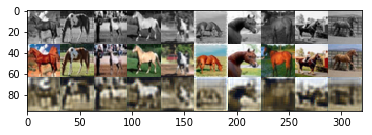

In [8]:
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.001, 
              'batch_size':100, 
              'epochs':25, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'regression_cnn',
              'visualize': False,
              'downsize_input':False,
}
args.update(args_dict)
cnn = train(args)

## c) Model is trained for 100 epochs. We observe that colour pallete is faded.<br>
## When model was trained with 10 epochs we observe blurry results in predictions.<br>
## The reason may be because of the fact that MSELoss encourages models to predict mean value. This results in Blurriness.

Loading data...
data/cifar-10-batches-py.tar.gz
Beginning training ...
Epoch [1/100], Loss: 0.0348
Epoch [1/100], Val Loss: 0.0398
Epoch [2/100], Loss: 0.0197
Epoch [2/100], Val Loss: 0.0196
Epoch [3/100], Loss: 0.0170
Epoch [3/100], Val Loss: 0.0167
Epoch [4/100], Loss: 0.0153
Epoch [4/100], Val Loss: 0.0151
Epoch [5/100], Loss: 0.0140
Epoch [5/100], Val Loss: 0.0139
Epoch [6/100], Loss: 0.0130
Epoch [6/100], Val Loss: 0.0130
Epoch [7/100], Loss: 0.0122
Epoch [7/100], Val Loss: 0.0123
Epoch [8/100], Loss: 0.0117
Epoch [8/100], Val Loss: 0.0116
Epoch [9/100], Loss: 0.0113
Epoch [9/100], Val Loss: 0.0111
Epoch [10/100], Loss: 0.0109
Epoch [10/100], Val Loss: 0.0107
Epoch [11/100], Loss: 0.0106
Epoch [11/100], Val Loss: 0.0103
Epoch [12/100], Loss: 0.0103
Epoch [12/100], Val Loss: 0.0100
Epoch [13/100], Loss: 0.0101
Epoch [13/100], Val Loss: 0.0098
Epoch [14/100], Loss: 0.0099
Epoch [14/100], Val Loss: 0.0096
Epoch [15/100], Loss: 0.0097
Epoch [15/100], Val Loss: 0.0094
Epoch [16/100], L

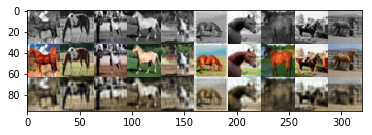

In [9]:
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.001, 
              'batch_size':100, 
              'epochs':100, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'regression_cnn',
              'visualize': False,
              'downsize_input':False,
}
args.update(args_dict)
cnn = train(args)

Loading data...
data/cifar-10-batches-py.tar.gz
Beginning training ...
Epoch [1/10], Loss: 0.0271
Epoch [1/10], Val Loss: 0.0295
Epoch [2/10], Loss: 0.0191
Epoch [2/10], Val Loss: 0.0191
Epoch [3/10], Loss: 0.0163
Epoch [3/10], Val Loss: 0.0162
Epoch [4/10], Loss: 0.0148
Epoch [4/10], Val Loss: 0.0147
Epoch [5/10], Loss: 0.0138
Epoch [5/10], Val Loss: 0.0137
Epoch [6/10], Loss: 0.0131
Epoch [6/10], Val Loss: 0.0129
Epoch [7/10], Loss: 0.0124
Epoch [7/10], Val Loss: 0.0123
Epoch [8/10], Loss: 0.0119
Epoch [8/10], Val Loss: 0.0118
Epoch [9/10], Loss: 0.0114
Epoch [9/10], Val Loss: 0.0114
Epoch [10/10], Loss: 0.0111
Epoch [10/10], Val Loss: 0.0110
Generating predictions...


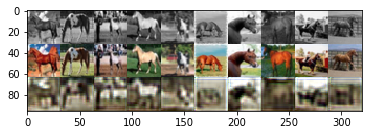

In [11]:
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.001, 
              'batch_size':100, 
              'epochs':10, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'regression_cnn',
              'visualize': False,
              'downsize_input':False,
}
args.update(args_dict)
cnn = train(args)

## d) All 3 colour dimesions in RGB are highly correlated with variations in intensity. It can create issues with grayscale images as bright spots can create problems. It will force the network to predict similar values in all colour dimensions.

## A better colour space option is to use HSV - V(brightness), H(Hue) and S(Saturation)

## e) Minimising MSE encourages the model to predict values closer to mean of training data. This results in blurry images.